In [1]:
# import dependencies
import tweepy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import config
import numpy as np
import time

In [2]:
# get tweepy credentials from config.py and pass them to get authentication
auth = tweepy.OAuthHandler(config.consumer_key, config.consumer_secret)
auth.set_access_token(config.access_token, config.access_token_secret)
api = tweepy.API(auth)
# initialize Vader analyzer
analyzer = SentimentIntensityAnalyzer()

In [3]:
# create news media list
news_media = ['@BBCNews','@CBSNews','@CNN','@FoxNews','@nytimes']
# create a dataframe to save results
result_df = pd.DataFrame(columns = ['news_media','Tweet','Tweet_Date','Sentiment_Compound',
                                 'Sentiment_Positive','Sentiment_Neutral','Sentiment_Negative'])
# define number of tweets to retrieve for analysis
num_tweets = 100
# capture report date to use on charts
report_date = time.strftime("%x")

In [4]:
# loop through all news media to retrieve tweets and analyze sentiments
for media in news_media:
    # use extended mode to search for the full text of each tweet
    for tweet in tweepy.Cursor(api.user_timeline,id=media,tweet_mode='extended').items(num_tweets):
        # use try except to determine if the tweet is a retweet
        try:
            # if it is a retweet and retweeted_status exists, retrieve the full text which is in retweeted_status dict
            text = tweet.retweeted_status.full_text
        # if it is an original tweet, retrieve the full text in the full_text field
        except AttributeError:
            text = tweet.full_text
        # analyze the sentiment scores and save them to the result dataframe
        sentiment_comp = analyzer.polarity_scores(text)['compound']
        sentiment_pos = analyzer.polarity_scores(text)['pos']
        sentiment_neu = analyzer.polarity_scores(text)['neu']
        sentiment_neg = analyzer.polarity_scores(text)['neg']
        result_df = result_df.append({'News_Media':media,
                                      'Tweet':text,
                                        'Tweet_Date':tweet.created_at,
                                        'Sentiment_Compound':sentiment_comp,
                                        'Sentiment_Positive':sentiment_pos,
                                        'Sentiment_Neutral':sentiment_neu,
                                        'Sentiment_Negative':sentiment_neg},
                                        ignore_index=True)
# save results to csv file
result_df.to_csv('tweet_sentiment_scores_by_news_media.csv',index=False)

In [5]:
# define the x axis and y axis to plot for each news media
y_axis_BBC = result_df.loc[result_df['News_Media'] == '@BBCNews']['Sentiment_Compound']
y_axis_CBS = result_df.loc[result_df['News_Media'] == '@CBSNews']['Sentiment_Compound']
y_axis_CNN = result_df.loc[result_df['News_Media'] == '@CNN']['Sentiment_Compound']
y_axis_FOX = result_df.loc[result_df['News_Media'] == '@FoxNews']['Sentiment_Compound']
y_axis_NYT = result_df.loc[result_df['News_Media'] == '@nytimes']['Sentiment_Compound']
x_axis = np.arange(num_tweets)

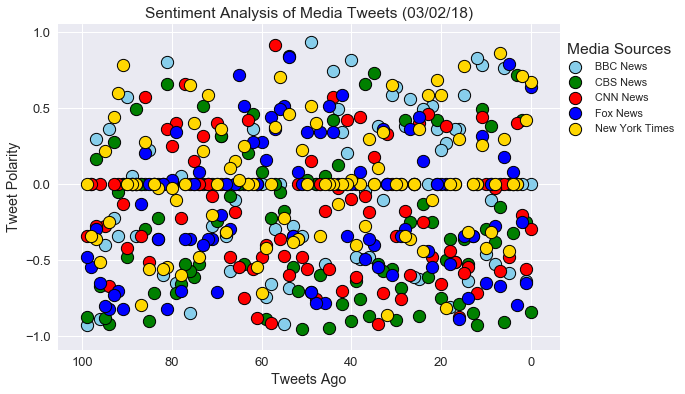

In [6]:
# use Seanborn style and set font scale
sns.set(font_scale=1.3)
# create a sub plot
fig, ax = plt.subplots(figsize = (9,6))
# define the size of circles
size = 150
# plot scatter for each news media
ax.scatter(x_axis,y_axis_BBC,marker='o',color='skyblue',linewidths=1,edgecolors='k',s=size)
ax.scatter(x_axis,y_axis_CBS,marker='o',color='g',linewidths=1,edgecolors='k',s=size)
ax.scatter(x_axis,y_axis_CNN,marker='o',color='r',linewidths=1,edgecolors='k',s=size)
ax.scatter(x_axis,y_axis_FOX,marker='o',color='b',linewidths=1,edgecolors='k',s=size)
ax.scatter(x_axis,y_axis_NYT,marker='o',color='Gold',linewidths=1,edgecolors='k',s=size)
# Invert the x axis to show numbers from 100 to 0
ax.invert_xaxis()
# set the ticks on y axis
ax.yaxis.set_ticks(np.arange(-1,1.5,.5))
# set the plot title and labels for x and y axis
ax.set_xlabel('Tweets Ago')
ax.set_ylabel('Tweet Polarity')
ax.set_title('Sentiment Analysis of Media Tweets (%s)'% report_date)
# set the legend for the plot
plt.legend(['BBC News','CBS News','CNN News','Fox News','New York Times'],loc=(1,.65),title='Media Sources',fontsize='x-small')
# save png image
plt.savefig('Sentiment_analysis_by_media.png')
# show plot
plt.show()

In [7]:
# calculate the average of sentiment scores by news media and round to 2 decimals
average = result_df.groupby('News_Media').mean().round(2)
# get the average sentiment compound score
average_compound = average['Sentiment_Compound']
# get the count of medias for x axis
num_media = len(average)
# get the min and max of average compound score and use them to set ticks on y axis
average_min = min(average_compound)
average_max = max(average_compound)
# define colors for the bars
colors = ['skyblue','g','r','b','Gold']


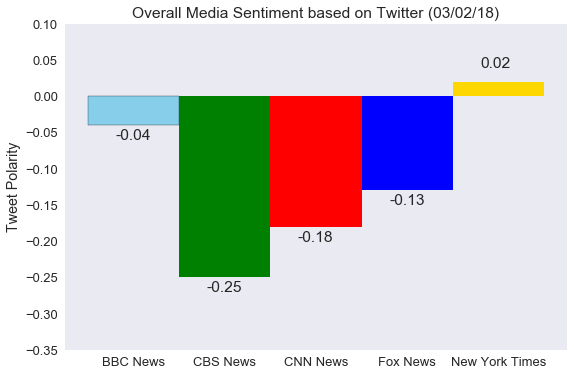

In [8]:
# use Seanborn style and select dark without grid and set font scale
sns.set(style='dark',font_scale=1.3)
# create a sub plot
fig, ax = plt.subplots(figsize = (9,6))
# plot a bar chart
ax.bar(np.arange(num_media),average_compound,color = colors,edgecolor='k',width=1,
       tick_label=['BBC News','CBS News','CNN News','Fox News','New York Times'])
# add average score values to the chart
for index, value in enumerate(average_compound):
    # if score greater than 0, add score on top of bar
    if value >= 0:
        ax.text(index - .2,value + .02,value)
    # if score less than 0, add score below bar
    else:
        ax.text(index - .2,value - .02,value)
# set the plot title and label for y axis
ax.set_ylabel('Tweet Polarity')
ax.set_title('Overall Media Sentiment based on Twitter (%s)'% report_date)
# set the ticks on y axis
ax.yaxis.set_ticks(np.arange(average_min - .1,average_max + .1,.05))   
# save png image
plt.savefig('Overall_media_sentiment.png')
# show plot
plt.show()